In [2]:
import json
import os
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [3]:
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests')
retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Added  req4Seasons.json
Added  reqA2D2.json
Added  reqA3D.json
Added  reqA9.json
Added  reqAmodalCityscapes.json
Added  reqAMUSE.json
Added  reqApolloScape.json
Added  reqArgoverse3DTracking.json
Added  reqArgoverseMotionForecasting.json
Added  reqAugKITTI.json
Added  reqBayAreaDataset.json
Added  reqBDD100k.json
Added  reqBDD100KAPS.json
Added  reqBeyondPASCAL.json
Added  reqBLVD.json
Added  reqBoreas.json
Added  reqBoschSmallTrafficLightsDataset.json
Added  reqBoschTL.json
Added  reqBoxy.json
Added  reqBrain4Cars.json
Added  reqCADC.json
Added  reqCADP.json
Added  reqCaltechLanes.json
Added  reqCaltechPedestrian.json
Added  reqCamVid.json
Added  reqCARLA100.json
Added  reqCarlaScenes.json
Added  reqCARRADADataset.json
Added  reqCarsDataset.json
Added  reqCityscapes3D.json
Added  reqCityscapesDVPS.json
Added  reqCODA.json
Added  reqComma2k19.json
Added  reqcommaai.json
Added  reqComplexUrbanDataset.json
Added  reqCooperativeDrivingDatasetCODD.json
Added  reqCrashD.json
Added  reqCULan

In [4]:
class scoring:
    def __init__(self, o_paper, lower_bound, upper_bound, impact_year):
        self.o_paper = o_paper
        self.lower_bound = o_paper['paperInfo']['year'] - lower_bound
        self.upper_bound = o_paper['paperInfo']['year'] + upper_bound
        self.impact_year = impact_year

    def number_citations_authors(self, author):
        """Returns a list where each entry is the number of citations a paper by a given auhtor had up until the given year. Ignores citations without year resulting in different counts compared to the one given by the API."""
        ls_citations = []
        for paper in self.o_paper['paperInfo']['authors'][author]['authorsPapers']:
            #print(paper)
            if 'year' in paper and paper['year'] is not None and paper['year'] <= self.upper_bound:
                numb_cit = 0
                for citation in paper['citations']:
                    if 'year' in citation and citation['year'] is not None and citation['year'] <= self.upper_bound and citation['year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def number_citations_ref(self, dimension='references', dimension_papers='citations'):
        """Like number_citations but the list elements represent the citations the references of a paper received."""
        ls_citations = []
        for paper in self.o_paper['paperInfo'][dimension]:
            if paper['year'] is not None and paper['year'] <= self.upper_bound and 'citations' in paper.keys():
                numb_cit = 0
                for citation in paper[dimension_papers]:
                    if citation['year'] is not None and citation['year'] <= self.upper_bound and citation['year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def just_citations(self):
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            if paper['year'] is not None and paper['year'] <= self.o_paper['paperInfo']['year'] + self.impact_year and paper['year'] >= self.lower_bound:
                        numb_cit += 1
                        #print((paper['year'] + self.impact_year))
        return numb_cit
    def reference_score(self):
        return calc_h_score(self.number_citations_ref())
    def citations_citations_score(self):
        return calc_h_score(self.number_citations_ref('citations', 'citations'))
    def citations_citations_sum(self):
        return np.sum(self.number_citations_ref('citations', 'citations'))
    def citations_single_author_score(self, author_number):
        return calc_h_score(self.number_citations_authors(author_number))


When do citations take off

In [5]:
def citation_timeline_array(retrieved_data):
    array = np.zeros([len(retrieved_data), 15])
    names = []
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        names.append(paper['id'])
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            for impact_year in range(-1, 2022-retrieved_data[paper_idx]['paperInfo']['year'], 1):
                scorer = scoring(paper, 200, 0, impact_year)
                #print(impact_year, scorer.just_citations())
                array[paper_idx][array_idx] = scorer.just_citations()
                array_idx += 1
    return array, names
array, name = citation_timeline_array(retrieved_data)
array

100%|██████████| 152/152 [00:00<00:00, 4735.21it/s]


array([[  1.,   7.,  89., ...,   0.,   0.,   0.],
       [  0.,   1.,  10., ...,   0.,   0.,   0.],
       [  0.,  30., 141., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [6]:
data = array
data = np.delete(data, np.s_[-11:], axis=1)
df = pd.DataFrame(data).set_axis(name)#
for column in range(df.shape[1]):
    if column >= 3:
        df = df[df[column] > 0]
data = np.array(df)

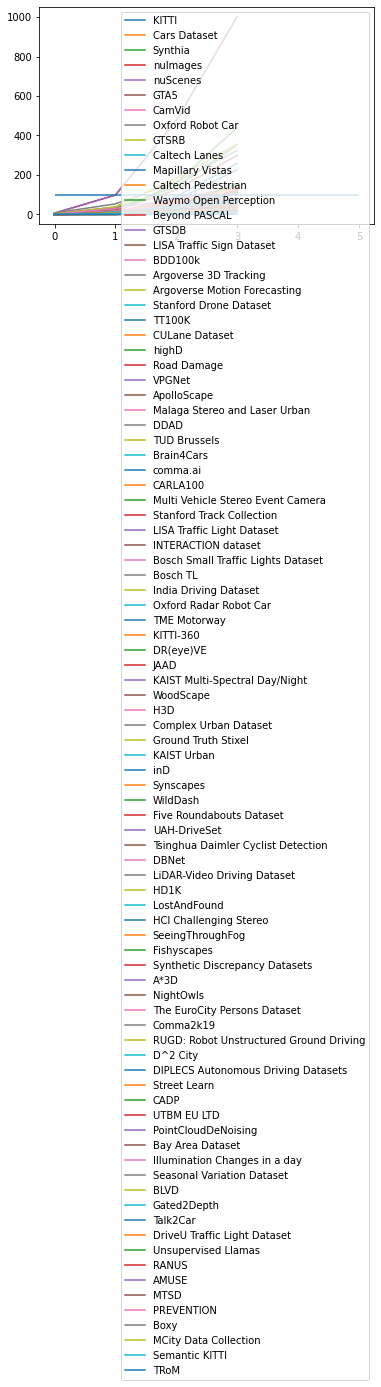

In [7]:
df_transpose = df.transpose()
df_transpose.plot()
plt.hlines(100, 0, 5)

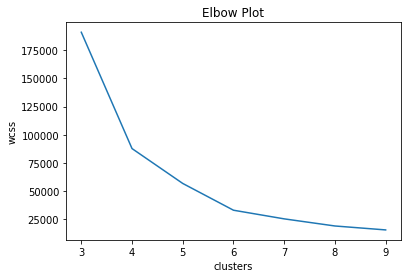

In [8]:
wcss = []
for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
plt.plot([*range(3, 10)], wcss)
plt.title('Elbow Plot')
plt.xlabel('clusters')
plt.ylabel('wcss')
plt.show()
#choose last bend

2
3
5
11
21
49


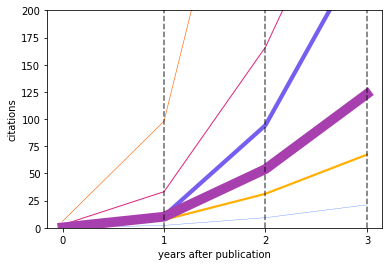

In [9]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data)
clusters = kmeans.cluster_centers_
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#A740AE']
labels = pd.Series(kmeans.labels_)
labels = labels.value_counts(ascending=True)
for label, cluster in enumerate(clusters):
    plt.plot([*range(0, cluster.shape[0])], cluster, alpha=1, label=label, color=colors[label] ,lw=labels.iloc[label]/5)
    print(labels.iloc[label])
y_lim = 200
plt.ylim(0, y_lim)
plt.vlines(1, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(2, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(3, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.xticks([*range(0, cluster.shape[0])])
plt.ylabel('citations')
plt.xlabel('years after publication')
#plt.title('Centers of Clusters from k-Means')
plt.savefig('citations_clustering.pdf', bbox_inches='tight')
#plt.legend()
#plt.hlines(50, 0, 5, linestyles='dashed', color='black')
plt.show()


In [10]:
np.lexsort((kmeans.cluster_centers_[:,-1]))

0

In [11]:
labels = pd.Series(kmeans.labels_)
labels.value_counts(ascending=True)

1     2
4     3
2     5
5    11
3    21
0    49
dtype: int64

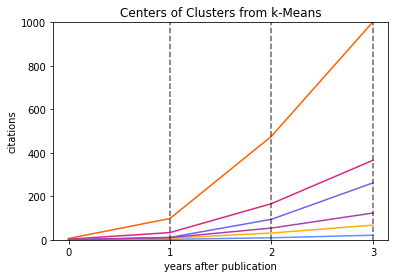

In [12]:
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#A740AE']
for idx, cluster in enumerate(clusters):
    plt.plot([*range(0, cluster.shape[0])], cluster, alpha=1, color=colors[idx])
y_lim = 1000
plt.ylim(0, y_lim)
plt.vlines(1, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(2, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(3, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.xticks([*range(0, cluster.shape[0])])
plt.ylabel('citations')
plt.xlabel('years after publication')
plt.title('Centers of Clusters from k-Means')
plt.savefig('citations_clustering_1000.svg')
#plt.hlines(50, 0, 5, linestyles='dashed', color='black')
plt.show()

In [13]:
def calc_h_score(citations):
    if citations:
        citations = np.array(citations)
        n         = citations.shape[0]
        array     = np.arange(1, n+1)
        # reverse sorting
        citations = np.sort(citations)[::-1]
        # intersection of citations and k
        h_idx = np.max(np.minimum(citations, array))
        return h_idx
    else:
        return 0

In [14]:
'''def expected_impact_score(o_paper, upper_bound, alpha=1, beta=1, gamma=1, theta=1): #Todo sum of weights = 1
    lower_bound = 5
    scorer = scoring(o_paper, lower_bound, upper_bound, 3)
    citation_c = scorer.just_citations(o_paper)
    reference_score_c = scorer.reference_score(o_paper)
    citations_citations_c = scorer.citations_citations_score(o_paper)
    ls_author_scores = []
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(o_paper, author_number)
        ls_author_scores.append(single_author_score)
    median_author_score = np.mean(ls_author_scores)
    #print('Median author score', median_author_score)
    return round(alpha*reference_score_c + beta*citations_citations_c + gamma*citation_c + theta*median_author_score, 1)'''

"def expected_impact_score(o_paper, upper_bound, alpha=1, beta=1, gamma=1, theta=1): #Todo sum of weights = 1\n    lower_bound = 5\n    scorer = scoring(o_paper, lower_bound, upper_bound, 3)\n    citation_c = scorer.just_citations(o_paper)\n    reference_score_c = scorer.reference_score(o_paper)\n    citations_citations_c = scorer.citations_citations_score(o_paper)\n    ls_author_scores = []\n    for author_number, author in enumerate(o_paper['paperInfo']['authors']):\n        single_author_score = scorer.citations_single_author_score(o_paper, author_number)\n        ls_author_scores.append(single_author_score)\n    median_author_score = np.mean(ls_author_scores)\n    #print('Median author score', median_author_score)\n    return round(alpha*reference_score_c + beta*citations_citations_c + gamma*citation_c + theta*median_author_score, 1)"

In [15]:
def create_modelling_df(retrieved_data, lower_bound, upper_bound, impact_year):
    array = np.zeros([len(retrieved_data), 4])

    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            reference_score_c = scorer.reference_score()
            citations_citations_c = scorer.citations_citations_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            median_author_score = round(np.mean(ls_author_scores), 0)
            array[paper_idx][:4] = [citation_c, citations_citations_c, reference_score_c,  median_author_score]
            array_idx += 1
    names = []
    year = []
    sensors = []
    frames = []
    similar_age_3m = []
    row_w_missing_data = []
    for idx_paper, paper in enumerate(retrieved_data):
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            similar_age_3m_value = paper['altmetrics'][2]['similar_age_3m_percentile']
        except:
            row_w_missing_data.append(idx_paper)
            continue
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
            if paper['frames'] != "-":
                frames_value = (paper['frames'])
            else:
                row_w_missing_data.append(idx_paper)
                continue
        except:
            row_w_missing_data.append(idx_paper)
            continue
        frames.append(frames_value)
        sensors.append(sensors_value)
        similar_age_3m.append(similar_age_3m_value)
    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[row_w_missing_data])
    df['sensors'] = sensors
    df['frames'] = frames
    df['similar_age_3m_percentile'] = similar_age_3m
    cols = list(df.columns)
    cols[:4] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score']
    df.columns = cols


    #print(row_w_missing_data)
    df = df[df.year <= 2019]
    return df

In [16]:
def convert_data(df, drop='citations_citations_c', dependent_var='citation_c'):
    replacement = df.at['Street Learn', 'frames'].replace(',', '')
    #print(replacement)
    df.at['Street Learn', 'frames'] = replacement
    modelling_df = df
    #modelling_df = modelling_df.drop(['BDD100k', 'Argoverse Motion Forecasting'], axis=0)
    modelling_df = modelling_df.drop([drop], axis=1)
    for idx_column, col in enumerate(modelling_df.columns):
        modelling_df[col] = modelling_df[col].astype("float")
    for idx, variable in enumerate(modelling_df):
        plt.scatter(modelling_df[variable], modelling_df[dependent_var])
        plt.xlabel(list(modelling_df.columns)[idx])
        plt.show()
    print(modelling_df.frames.max())
    modelling_df[dependent_var] = np.log(modelling_df[dependent_var] + 1)
    modelling_df.frames = np.log(modelling_df.frames + 1)
    return modelling_df
def normalize(modelling_df, dependent_var='citation_c'):
    for idx_column, col in enumerate(modelling_df.columns):
        if col != dependent_var:
                modelling_df[col] = (modelling_df[col]-modelling_df[col].mean())/(modelling_df[col].std())

    #modelling_df['similar_age_3m_percentilec2'] = np.square(modelling_df.similar_age_3m_percentile)
    modelling_df['mean_author_score2'] = np.square(modelling_df.mean_author_score)
    return modelling_df

def modelling(modelling_df, dependent_var='citation_c'):
    independent_vars = modelling_df.drop([dependent_var], axis=1)
    X = add_constant(independent_vars)
    y = modelling_df[dependent_var]
    mod = sm.OLS(y, independent_vars.assign(intercept=1))
    res = mod.fit()
    print(res.summary())
    test = sm.stats.het_breuschpagan(res.resid, res.model.exog)
    print('test', test)
    vif = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
    print(vif)

    fitted_y = res.fittedvalues
    plot = sns.residplot(x=fitted_y, y=modelling_df[dependent_var], data=modelling_df, lowess=True)
    plt.show()
    for variable in independent_vars:
        plot = sns.residplot(x=independent_vars[variable], y=modelling_df[dependent_var], data=modelling_df, lowess=True)
        plt.show()
    return res, fitted_y, y, independent_vars

100%|██████████| 152/152 [00:04<00:00, 32.35it/s]


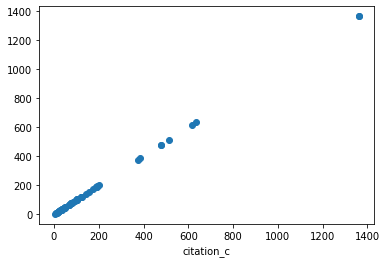

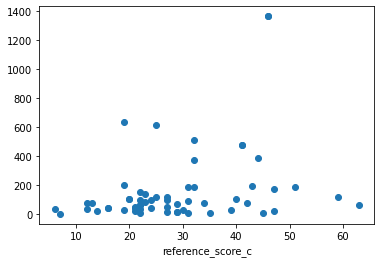

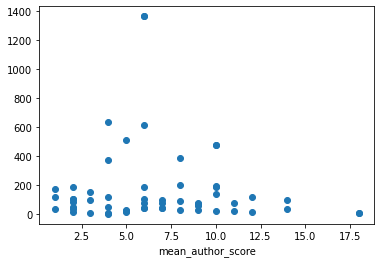

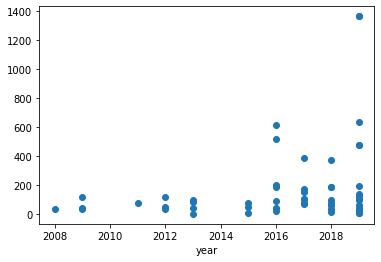

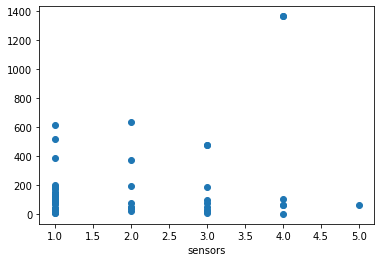

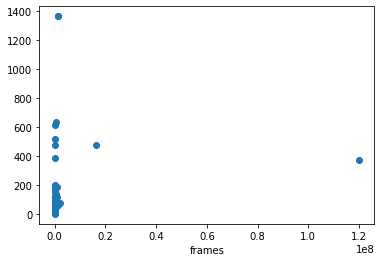

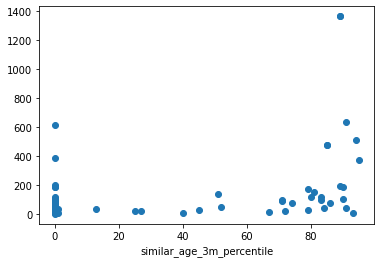

120000000.0
                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     3.938
Date:                Sun, 18 Sep 2022   Prob (F-statistic):            0.00166
Time:                        18:34:00   Log-Likelihood:                -82.258
No. Observations:                  59   AIC:                             180.5
Df Residuals:                      51   BIC:                             197.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
reference_

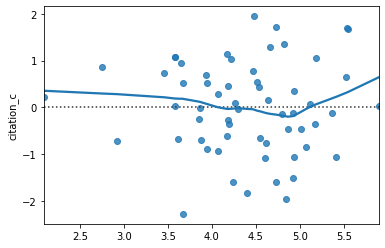

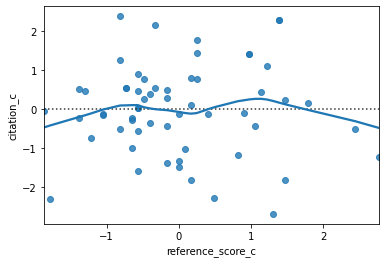

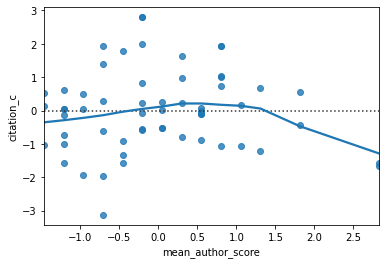

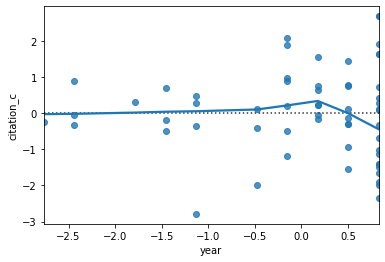

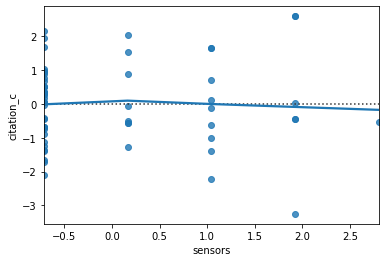

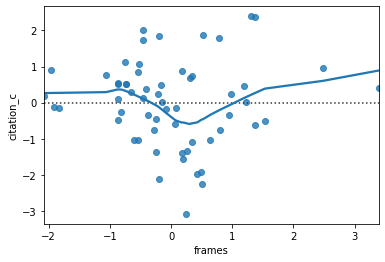

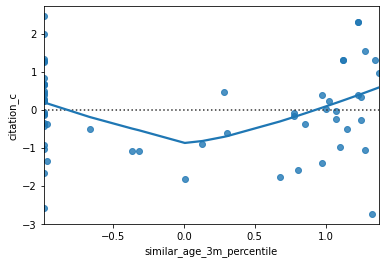

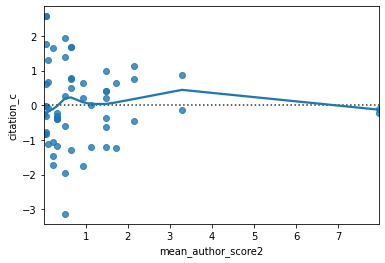

In [17]:
df = create_modelling_df(retrieved_data, 3, 0, 3)
modelling_df = convert_data(df)
modelling_df_normalized = normalize(modelling_df)
res, fitted_y, y, x = modelling(modelling_df_normalized)

100%|██████████| 152/152 [00:01<00:00, 122.59it/s]


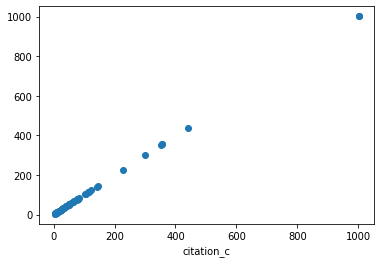

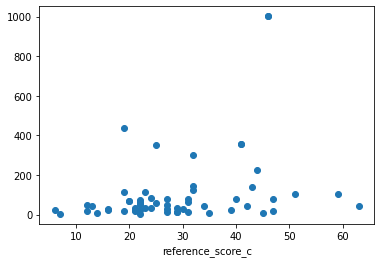

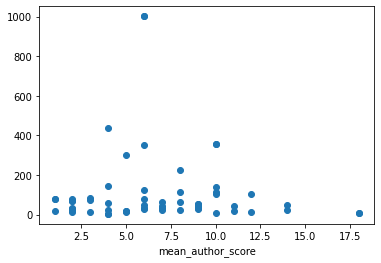

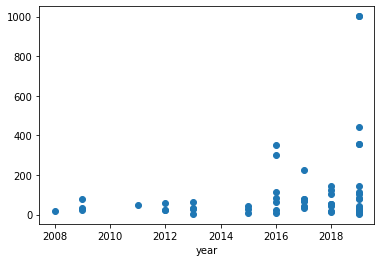

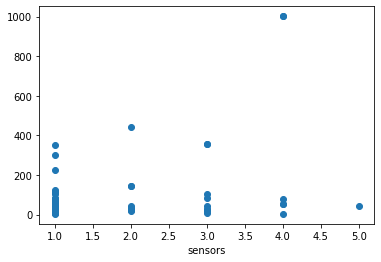

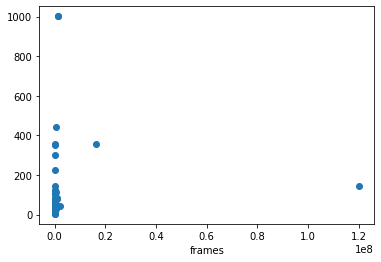

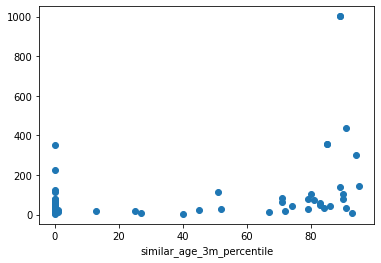

120000000.0
                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     3.853
Date:                Sun, 18 Sep 2022   Prob (F-statistic):            0.00195
Time:                        18:34:02   Log-Likelihood:                -81.499
No. Observations:                  59   AIC:                             179.0
Df Residuals:                      51   BIC:                             195.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
reference_

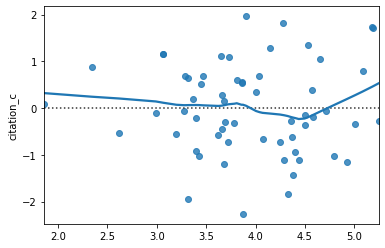

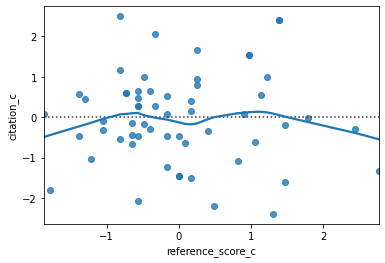

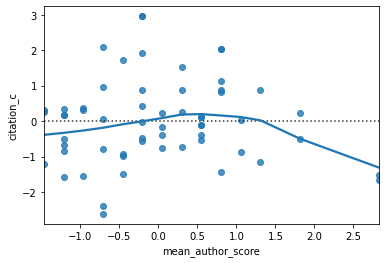

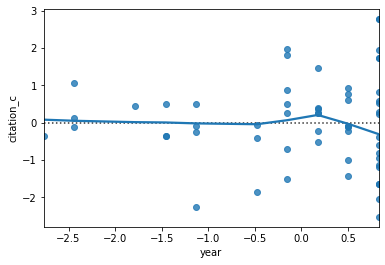

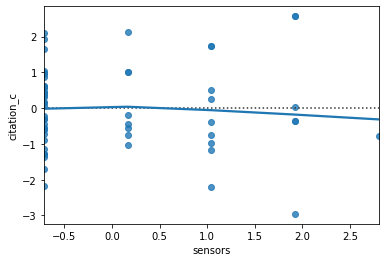

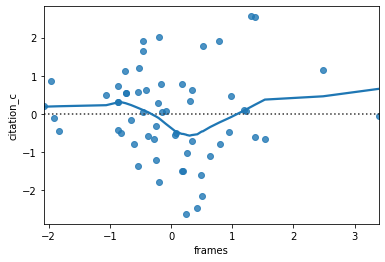

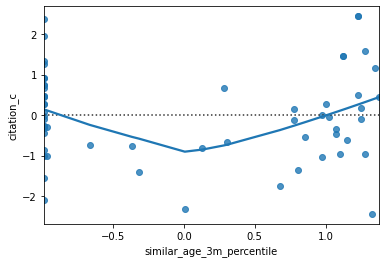

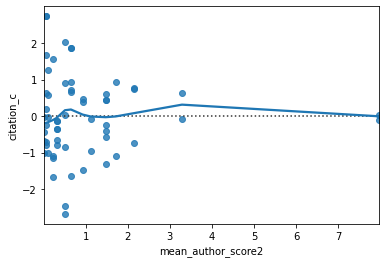

In [18]:
df = create_modelling_df(retrieved_data, 3, 0, 2)
modelling_df = convert_data(df)
modelling_df_normalized = normalize(modelling_df)
res, fitted_y, y, x = modelling(modelling_df_normalized)

In [19]:
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests')
retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Added  req4Seasons.json
Added  reqA2D2.json
Added  reqA3D.json
Added  reqA9.json
Added  reqAmodalCityscapes.json
Added  reqAMUSE.json
Added  reqApolloScape.json
Added  reqArgoverse3DTracking.json
Added  reqArgoverseMotionForecasting.json
Added  reqAugKITTI.json
Added  reqBayAreaDataset.json
Added  reqBDD100k.json
Added  reqBDD100KAPS.json
Added  reqBeyondPASCAL.json
Added  reqBLVD.json
Added  reqBoreas.json
Added  reqBoschSmallTrafficLightsDataset.json
Added  reqBoschTL.json
Added  reqBoxy.json
Added  reqBrain4Cars.json
Added  reqCADC.json
Added  reqCADP.json
Added  reqCaltechLanes.json
Added  reqCaltechPedestrian.json
Added  reqCamVid.json
Added  reqCARLA100.json
Added  reqCarlaScenes.json
Added  reqCARRADADataset.json
Added  reqCarsDataset.json
Added  reqCityscapes3D.json
Added  reqCityscapesDVPS.json
Added  reqCODA.json
Added  reqComma2k19.json
Added  reqcommaai.json
Added  reqComplexUrbanDataset.json
Added  reqCooperativeDrivingDatasetCODD.json
Added  reqCrashD.json
Added  reqCULan

In [20]:
yr = 2022
array = np.empty([len(retrieved_data), 6])
array[:] = np.nan
names = []
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    scorer = scoring(o_paper, 200, yr, yr)
    reference = scorer.reference_score()
    citations_citations = scorer.citations_citations_score()
    citations = scorer.just_citations()
    ls_author_scores = []
    names.append(o_paper['id'])
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(author_number)
        ls_author_scores.append(single_author_score)
    author = np.mean(ls_author_scores)
    try:
        score = o_paper['altmetrics'][0]['score']
        total_readers = o_paper['altmetrics'][3]['total_readers']
    except:
        percentile = float("NaN")
        total_readers = float("NaN")
    array[paper_idx][:] = [citations, citations_citations, total_readers, score, reference, author,]
array

100%|██████████| 152/152 [00:01<00:00, 85.82it/s] 


array([[4.75100000e+03, 1.41000000e+02, 1.92300000e+03, 1.22500000e+01,
        1.30000000e+01, 3.12500000e+01],
       [1.62800000e+03, 1.02000000e+02, 3.49000000e+02, 3.00000000e+00,
        3.60000000e+01, 2.15000000e+01],
       [1.38100000e+03, 1.06000000e+02, 7.21000000e+02, 9.00000000e+00,
        3.70000000e+01, 1.26000000e+01],
       [1.36300000e+03, 5.50000000e+01, 1.11700000e+03, 2.25800000e+01,
        6.70000000e+01, 8.10000000e+00],
       [1.36300000e+03, 5.50000000e+01, 1.11700000e+03, 2.25800000e+01,
        6.70000000e+01, 8.10000000e+00],
       [1.14800000e+03, 1.07000000e+02, 6.21000000e+02, 3.97300000e+01,
        4.90000000e+01, 2.72500000e+01],
       [9.21000000e+02, 8.00000000e+01, 3.83000000e+02, 9.00000000e+00,
        2.80000000e+01, 2.60000000e+01],
       [8.50000000e+02, 6.40000000e+01, 4.86000000e+02, 3.50000000e+00,
        2.70000000e+01, 2.17500000e+01],
       [6.97000000e+02, 6.10000000e+01, 2.24000000e+02, 1.50000000e+00,
        1.90000000e+01, 

In [21]:
spider_web = pd.DataFrame(array, columns=['citations', 'citations_citations', 'total_readers', 'score', 'reference', 'author']).set_axis(names)
spider_web['Altmetric'] = spider_web.score.rank(pct = True)
spider_web['cit'] = spider_web.citations.rank(pct = True)
spider_web['h-cit'] = spider_web.citations_citations.rank(pct = True)
spider_web['readers'] = spider_web.total_readers.rank(pct = True)
spider_web['refs'] = spider_web.reference.rank(pct = True)
spider_web['authors'] = spider_web.author.rank(pct = True)
spider_web

,citations,citations_citations,total_readers,score,reference,author,Altmetric,cit,h-cit,readers,refs,authors
KITTI,4751.0,141.0,1923.0,12.25,13.0,31.250000,0.802632,1.000000,1.000000,1.000000,0.082237,0.967105
Cars Dataset,1628.0,102.0,349.0,3.00,36.0,21.500000,0.483553,0.993421,0.980263,0.860000,0.687500,0.789474
Synthia,1381.0,106.0,721.0,9.00,37.0,12.600000,0.740132,0.986842,0.986842,0.980000,0.707237,0.453947
nuImages,1363.0,55.0,1117.0,22.58,67.0,8.100000,0.917763,0.976974,0.930921,0.990000,0.957237,0.187500
nuScenes,1363.0,55.0,1117.0,22.58,67.0,8.100000,0.917763,0.976974,0.930921,0.990000,0.957237,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...
exiD,0.0,0.0,22.0,9.33,0.0,8.666667,0.753289,0.029605,0.055921,0.146667,0.026316,0.217105
K-Radar,0.0,0.0,11.0,2.25,23.0,5.333333,0.394737,0.029605,0.055921,0.093333,0.322368,0.059211
On Salience-Sensitive Sign Classification in Autonomous Vehicle Path Planning,0.0,0.0,2.0,1.25,15.0,14.600000,0.253289,0.029605,0.055921,0.040000,0.131579,0.526316
R3 Driving Dataset,0.0,0.0,11.0,2.25,26.0,7.363636,0.394737,0.029605,0.055921,0.093333,0.401316,0.138158


0
0
0
1
1
1
2
2
2
3
3
3


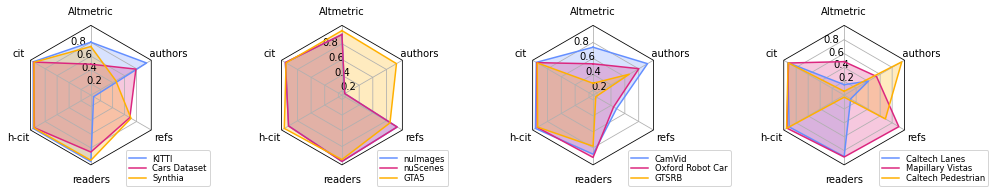

In [22]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

N = 6
theta = radar_factory(N, frame='polygon')
values = [[], [], [], []]
web_names = [[], [], [], []]
data = []
k = 0
for i in range(12):
    row = (spider_web.iloc[i][-6:])
    if i%3 == 0 and i != 0:
        k += 1
    print(k)
    values[k].append( list(row))
    web_names[k].append(row.name)

dimension_names = []
for name in enumerate(list(spider_web.columns[-6:])):
    #print(name[1])
    dimension_names.append(name[1].replace('author', '   author'))
data = [dimension_names, ('', web_names[0], values[0]), ('', web_names[1], values[1]), ('', web_names[2], values[2]), ('', web_names[3], values[3])]

#print(data)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(16, 4), nrows=1, ncols=4,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.8, hspace=0.0, top=0.95, bottom=0.05)

# Plot the four cases from the example data on separate axes
colors = ['#648fff', '#dc267f', '#ffb000'] #['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000']
for ax, (title, label, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.legend(label, loc=(0.75, -0.15),
                          labelspacing=0.1, fontsize='small')

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

#fig.text(0.5, 0.7, 'Influence of Successful Papers',
#         horizontalalignment='center', color='black', weight='bold',
#         size='large')
plt.savefig('spider_web_at.pdf', bbox_inches='tight')
plt.show()

[['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors'], ('', ['Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE'], [[0.881578947368421, 0.5592105263157895, 0.5361842105263158, 0.6333333333333333, 0.6611842105263158, 0.3881578947368421], [0.8125, 0.5230263157894737, 0.47368421052631576, 0.7233333333333334, 0.9967105263157895, 0.8717105263157895], [0.6907894736842105, 0.4309210526315789, 0.3519736842105263, 0.47333333333333333, 0.8519736842105263, 0.506578947368421]]), ('', ['MAVD Multimodal Audio-Visual Detection', 'MOTSynth', 'RoadAnomaly21'], [[0.2894736842105263, 0.3684210526315789, 0.26644736842105265, 0.6066666666666667, 0.75, 0.17105263157894737], [0.5921052631578947, 0.28289473684210525, 0.1513157894736842, 0.44333333333333336, 0.9736842105263158, 0.5131578947368421], [0.48355263157894735, 0.29276315789473684, 0.26644736842105265, 0.20666666666666667, 0.7072368421052632, 0.6842105263157895]])]


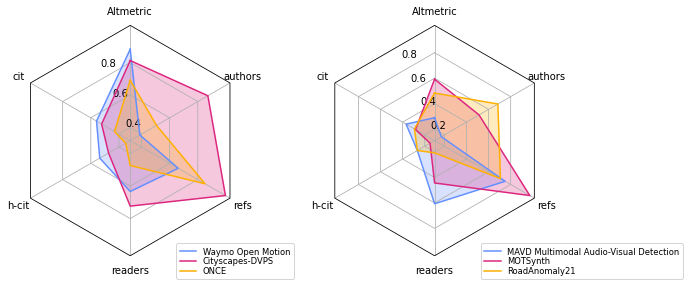

In [23]:
N = 6
theta = radar_factory(N, frame='polygon')
'''values = [[], [], [], []]
web_names = [[], [], [], []]
for i in range(2):
    row = (spider_web.iloc[i][-6:])
    values[0].append(list(row))
    web_names[0].append(row.name)'''

values_21 = [[], []]
web_names_21 = [[], []]
for index, i in enumerate(['Waymo Open Motion', 'SemKITTI-DVPS', 'Cityscapes-DVPS', 'ONCE', 'MAVD Multimodal Audio-Visual Detection', 'MOTSynth', 'RoadAnomaly21']):
    # top 6 ['Waymo Open Motion', 'SemKITTI-DVPS', 'Cityscapes-DVPS', 'ONCE', 'RoadAnomaly21', 'MOTSynth', 'RoadAnomaly21'] #'SemKITTI-DVPS', 'Cityscapes-DVPS' are the same
    if i == 'SemKITTI-DVPS':
        continue
    row = (spider_web.loc[i][-6:])
    if index <= 3:
        values_21[0].append(list(row))
        web_names_21[0].append(row.name)
    else:
        values_21[1].append(list(row))
        web_names_21[1].append(row.name)
dimension_names = []

for name in enumerate(list(spider_web.columns[-6:])):
    #print(name[1])
    dimension_names.append(name[1].replace('_', '\n'))
data = [dimension_names, ('', web_names_21[0], values_21[0]), ('', web_names_21[1], values_21[1])]

print(data)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.2, hspace=0.10, top=0.9, bottom=0.1)

# Plot the four cases from the example data on separate axes
colors = ['#648fff', '#dc267f', '#ffb000'] #['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000']
for ax, (title, label, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    '''ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.4),
                 horizontalalignment='center', verticalalignment='center')'''
    a = 0
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        a += 1
    ax.set_varlabels(spoke_labels)
    ax.legend(label, loc=(0.7, -0.1),
                          labelspacing=0.1, fontsize='small')

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

plt.savefig('spider_web_at_best_of_21.pdf', bbox_inches='tight')
plt.show()

In [24]:
same_start_year = False
if same_start_year:
    references_array = np.empty([len(retrieved_data), 15])
    citations_array = np.empty([len(retrieved_data), 15])
    citations_citations_array = np.empty([len(retrieved_data), 15])
    author_array = np.empty([len(retrieved_data), 15])

    references_array[:] = np.nan
    citations_array[:] = np.nan
    citations_citations_array[:] = np.nan
    author_array[:] = np.nan
    names = []
    for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
        names.append(o_paper['id'])
        for index in range(16):
            yr = o_paper['paperInfo']['year'] + index
            if yr > 2022:
                break
            scorer = scoring(o_paper, 50, index, index)

            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            author_array[paper_idx, index] = np.mean(ls_author_scores)
            references_array[paper_idx, index] = scorer.reference_score()
            citations_array[paper_idx, index] = scorer.just_citations()
            citations_citations_array[paper_idx, index] = scorer.citations_citations_score()

In [25]:
if not same_start_year:
    references_array = np.empty([len(retrieved_data), 15])
    citations_array = np.empty([len(retrieved_data), 15])
    citations_citations_array = np.empty([len(retrieved_data), 15])
    author_array = np.empty([len(retrieved_data), 15])
    citations_citations_sum_array = np.empty([len(retrieved_data), 15])
    references_array[:] = np.nan
    citations_array[:] = np.nan
    citations_citations_array[:] = np.nan
    author_array[:] = np.nan
    citations_citations_sum_array[:] = np.nan
    names = []
    for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
        names.append(o_paper['id'])
        for index in range(14, 0, -1): #index = 16 = year 2022
            dist = 2008+ index-o_paper['paperInfo']['year']
            if dist < 0:
                break
            scorer = scoring(o_paper, 50, dist, dist)

            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            author_array[paper_idx, index] = np.mean(ls_author_scores)
            references_array[paper_idx, index] = scorer.reference_score()
            citations_array[paper_idx, index] = scorer.just_citations()
            citations_citations_array[paper_idx, index] = scorer.citations_citations_score()
            citations_citations_sum_array[paper_idx, index] = scorer.citations_citations_sum()


100%|██████████| 152/152 [00:07<00:00, 20.18it/s]


In [26]:
author_df = pd.DataFrame(author_array).set_axis(names)
references_df = pd.DataFrame(references_array).set_axis(names)
citations_df = pd.DataFrame(citations_array).set_axis(names)
citations_citations_df = pd.DataFrame(citations_citations_array).set_axis(names)
citations_citations_sum_df = pd.DataFrame(citations_citations_sum_array).set_axis(names)
for i in range(15):
    author_df.iloc[:, i] = author_df.iloc[:, i].rank(pct = True)
    references_df.iloc[:, i] = references_df.iloc[:, i].rank(pct = True)
    citations_df.iloc[:, i] = citations_df.iloc[:, i].rank(pct = True)
    citations_citations_df.iloc[:, i] = citations_citations_df.iloc[:, i].rank(pct = True)
author_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
KITTI,NaN,NaN,NaN,NaN,NaN,0.071429,0.052632,0.045455,0.03125,0.243902,0.327586,0.521978,0.778261,0.970149,0.967105
Cars Dataset,NaN,NaN,NaN,NaN,NaN,0.142857,0.105263,0.159091,0.21875,0.280488,0.293103,0.373626,0.434783,0.593284,0.789474
Synthia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25000,0.365854,0.413793,0.450549,0.426087,0.447761,0.453947
nuImages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.236264,0.178261,0.160448,0.187500
nuScenes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.236264,0.178261,0.160448,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
exiD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.217105
K-Radar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059211
On Salience-Sensitive Sign Classification in Autonomous Vehicle Path Planning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496269,0.526316
R3 Driving Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.119403,0.138158


In [27]:
percentile_scores = {"authors": author_df, "references": references_df, "citations": citations_df, "citations_citations": citations_citations_df}

In [28]:
def relevance_score(scores, alpha=0.25, beta=0.25, gamma=0.25, theta=0.25, relative_c2=False): #Todo sum of weights = 1
    result = scores['references']*alpha + scores['authors']*beta + scores['citations']*gamma + scores['citations_citations']*theta
    if relative_c2:
        result = scores['citations_citations']/scores['citations']
    return result

In [29]:
relevance_scores = relevance_score(percentile_scores).round(3)
relevance_scores.columns = [*range(2008, 2023)]


In [30]:
relevance_scores = relevance_scores[pd.notna(relevance_scores[2019])]
relevance_scores = relevance_scores.sort_values([2022], ascending=[False])
relevance_scores.to_csv('infSco_equal_weigths.csv', header=[*range(2008, 2023)])

In [31]:
relevance_scores.duplicated(subset=[2022])

GTA5                         False
LISA Traffic Sign Dataset    False
CULane Dataset               False
Caltech Pedestrian           False
Cars Dataset                 False
                             ...  
MCity Data Collection        False
Unsupervised Llamas           True
Comma2k19                    False
BLVD                         False
PointCloudDeNoising          False
Length: 91, dtype: bool

In [32]:
relevance_scores = relevance_score(percentile_scores, alpha=0, beta=0, gamma=0.5, theta=0.5)

In [33]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#A740AE']
datasets = ['KITTI','Cars Dataset', 'Synthia', 'Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE']
interest = relevance_scores.loc[datasets]

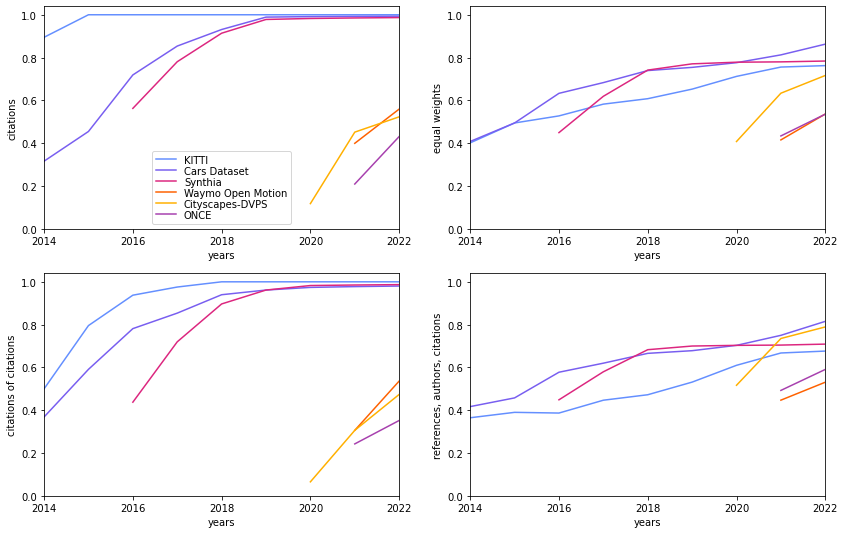

In [34]:
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('influence_scores.pdf')
plt.show()

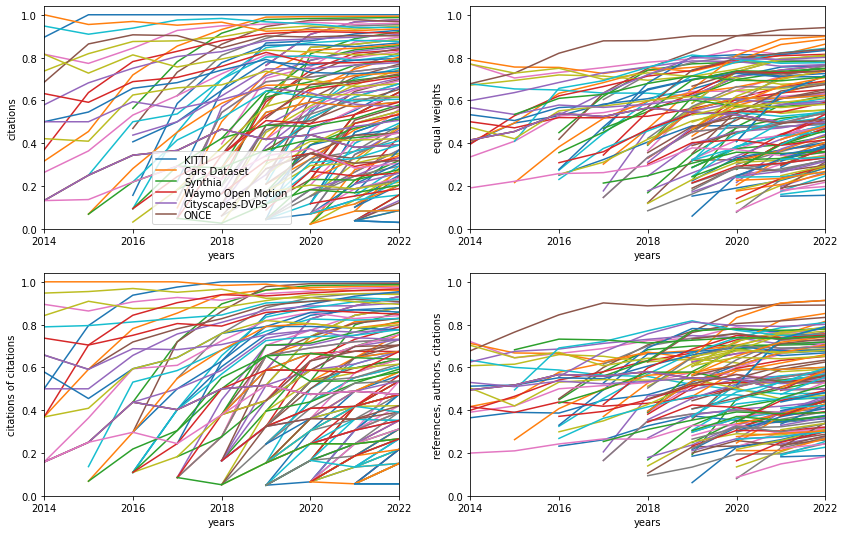

In [35]:
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.loc[row])
        ax.plot([*range(2008, 2023)], relevance_scores.iloc[i_row], label=relevance_scores.iloc[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('influence_scores_3.pdf')
plt.show()

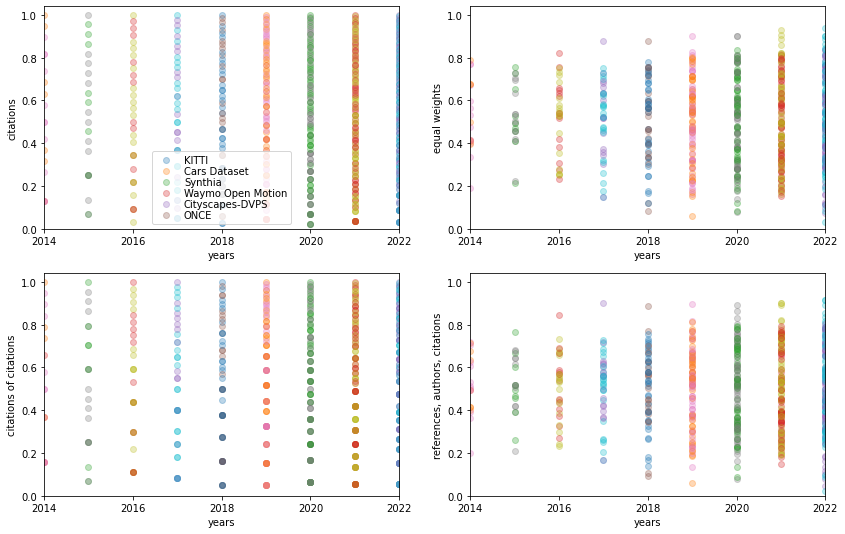

In [36]:
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.iloc[i_row])
        for i, score in enumerate(relevance_scores.iloc[i_row]):
            if score is not None:
                ax.scatter((2008+i), score, label=relevance_scores.iloc[i_row], alpha=0.3)
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('influence_scores_3.pdf')
plt.show()

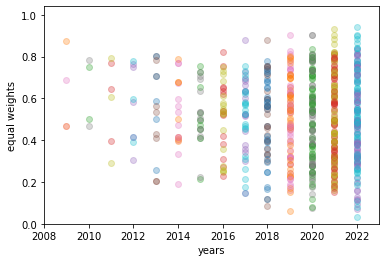

In [37]:
ws = [('equal weights', [0.25, 0.25, 0.25, 0.25])]
ax = plt.subplot()
#ax.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for (scenario_name, w) in ws:
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.iloc[i_row])
        for i, score in enumerate(relevance_scores.iloc[i_row]):
            if score is not None:
                ax.scatter((2008+i), score, label=relevance_scores.iloc[i_row], alpha=0.3)
    ax.set(xlim=(2008, 2023), ylim=(0, 1.04), xticks=[*range(2008, 2024, 2)], xlabel='years', ylabel=scenario_name)
    #if first:
    #    ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
    #    first = False
plt.savefig('influence_scores_3.pdf')
plt.show()

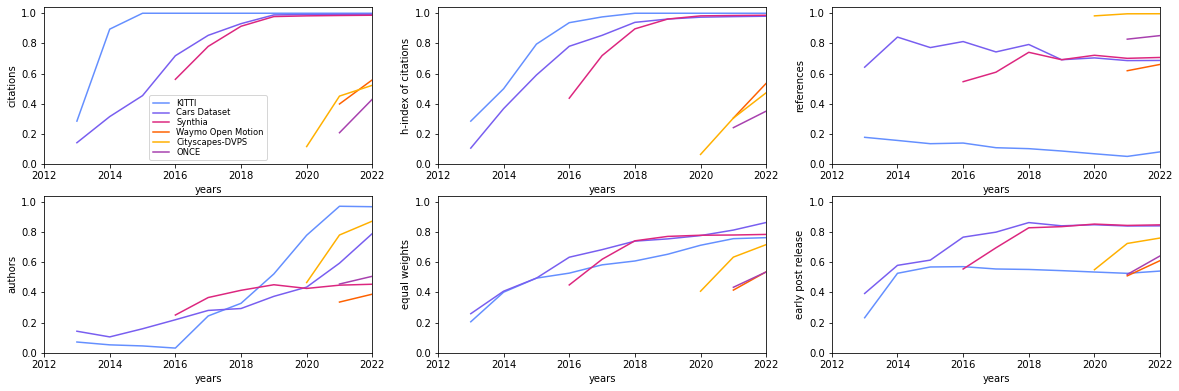

In [38]:
ws = [('citations', [0, 0, 1, 0]), ('h-index of citations', [0, 0, 0, 1]), ('references', [1, 0, 0, 0]), ('authors', [0, 1, 0, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('early post release', [0.5, 0, 0.5, 0])]
fig, axs = plt.subplots(figsize=(20, 8), nrows=2, ncols=3)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8, bottom=0.2)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2012, 2022), ylim=(0, 1.04), xticks=[*range(2012, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='small')
        first = False
plt.savefig('influence_scores2.pdf', bbox_inches='tight')
plt.show()

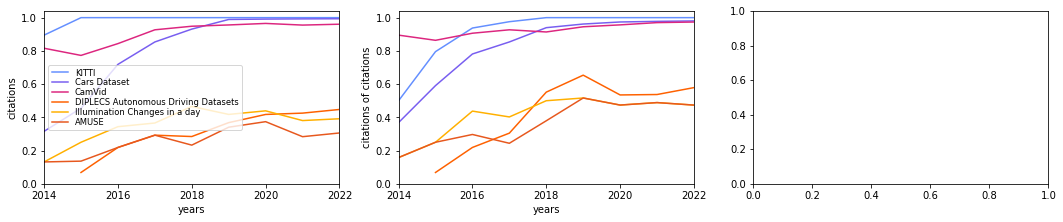

In [101]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#E7581E']
ws = [('citations', [0, 0, 1, 0]), ('citations of citations', [0, 0, 0, 1])]
fig, axs = plt.subplots(figsize=(18, 4), nrows=1, ncols=3)
fig.subplots_adjust(wspace=0.2, hspace=0, top=0.8, bottom=0.2)
datasets = ['KITTI', 'Cars Dataset', 'CamVid', 'DIPLECS Autonomous Driving Datasets', 'Illumination Changes in a day', 'AMUSE']
first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3], relative_c2=False)
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='best', labelspacing=0.1, fontsize='small')
        first = False
#plt.savefig('influence_scores2.pdf')
plt.show()

In [102]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#A740AE']
datasets = ['KITTI','Synthia', 'nuScenes', 'Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE']
interest = relevance_scores.loc[datasets]

In [103]:
author_df = pd.DataFrame(author_array).set_axis(names)
references_df = pd.DataFrame(references_array).set_axis(names)
citations_df = pd.DataFrame(citations_array).set_axis(names)
citations_citations_df = pd.DataFrame(citations_citations_array).set_axis(names)
citations_citations_sum_df = pd.DataFrame(citations_citations_sum_array).set_axis(names)

C:\Users\jonas\AppData\Local\Temp\ipykernel_9496\1306375779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citations_citations_rank'] = citations_citations_sum_df.iloc[:144][14]#/citations_df.iloc[:144][14]).rank(pct = True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_9496\1306375779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citation_rank'] = citations_df.iloc[:144][14] #.rank(pct = True)


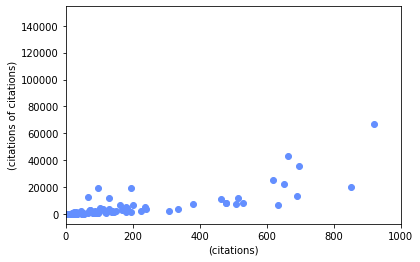

In [104]:
df = citations_citations_sum_df.iloc[:144]
df['citations_citations_rank'] = citations_citations_sum_df.iloc[:144][14]#/citations_df.iloc[:144][14]).rank(pct = True)
df['citation_rank'] = citations_df.iloc[:144][14] #.rank(pct = True)
plt.scatter(df.citation_rank, df.citations_citations_rank, color='#648fff')
plt.xlabel('(citations)')
plt.xlim(0, 1000)
plt.ylabel('(citations of citations)')
plt.savefig('citations_of_citations_per_citation.pdf')
plt.show()

In [105]:
from scipy.stats import pearsonr
pearsonr(df.citation_rank, df.citations_citations_rank)
#correlation coeff, p-value

(0.9234657919986988, 6.065066943480365e-61)

In [106]:
x = pd.DataFrame(df.citation_rank)
mod = sm.OLS(df.citations_citations_rank, x.assign(intercept=1))
res = mod.fit()
print(res.summary())

                               OLS Regression Results                               
Dep. Variable:     citations_citations_rank   R-squared:                       0.853
Model:                                  OLS   Adj. R-squared:                  0.852
Method:                       Least Squares   F-statistic:                     822.6
Date:                      Sat, 17 Sep 2022   Prob (F-statistic):           6.07e-61
Time:                              19:41:56   Log-Likelihood:                -1461.2
No. Observations:                       144   AIC:                             2926.
Df Residuals:                           142   BIC:                             2932.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [107]:
score  = (df.citations_citations_rank - res.fittedvalues).rank(pct=True)

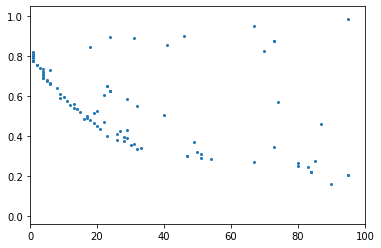

In [108]:
plt.scatter(df.citation_rank, list(score), alpha=1, s=4)
plt.xlim(0, 100)
plt.show()

In [109]:
res.params

citation_rank     30.833153
intercept       -454.415947
dtype: float64

In [110]:
score

KITTI                                      0.868056
Cars Dataset                               0.930556
Synthia                                    0.958333
nuImages                                   0.010417
nuScenes                                   0.010417
                                             ...   
Gated2Gated                                0.774306
GROUNDED                                   0.774306
MIT-AVT Clustered Driving Scene Dataset    0.819444
OpenMPD                                    0.791667
ScribbleKITTI                              0.774306
Length: 144, dtype: float64

C:\Users\jonas\AppData\Local\Temp\ipykernel_9496\2919532340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citations_citations_rank'] = citations_citations_df.iloc[:144][14].rank(pct = True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_9496\2919532340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citation_rank'] = citations_df.iloc[:144][14].rank(pct = True)


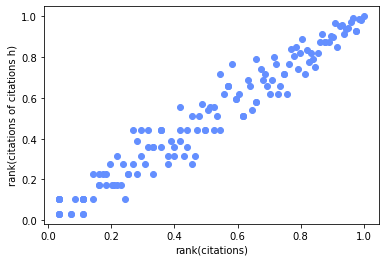

In [111]:
df = citations_citations_df.iloc[:144]
df['citations_citations_rank'] = citations_citations_df.iloc[:144][14].rank(pct = True)
df['citation_rank'] = citations_df.iloc[:144][14].rank(pct = True)
plt.scatter(df.citation_rank, df.citations_citations_rank, color='#648fff')
plt.xlabel('rank(citations)')
plt.ylabel('rank(citations of citations h)')
plt.savefig('citations_of_citations_per_citation.pdf')
plt.show()

In [112]:
from scipy.stats import pearsonr
pearsonr(df.citation_rank, df.citations_citations_rank)
#correlation coeff, p-value

(0.9716942427832064, 7.145656169993946e-91)